## 数据探索

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
%matplotlib inline

In [2]:
sns.set_style('whitegrid')
train = pd.read_csv("../data/7_titanic/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
hasnull_cols= {}
for col in train.columns: 
    if not train[col][train[col].isnull()].empty:
        hasnull_cols[col] = train[col][train[col].isnull()]
print(hasnull_cols.keys())
for key in hasnull_cols.keys():
    print(key, hasnull_cols[key].shape)

dict_keys(['Age', 'Cabin', 'Embarked'])
Age (177,)
Cabin (687,)
Embarked (2,)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


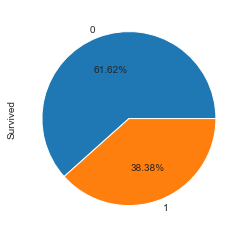

In [5]:
train['Survived'].value_counts().plot.pie(autopct = '%1.2f%%')

### 1.1补充缺失值

In [6]:
# 补充缺失值
train['Embarked'][train['Embarked'].isnull()] = train['Embarked'].dropna().mode().values
train['Cabin'].fillna('U0', inplace=True)

c:\users\10203524\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
# 补充age项的缺失值
from sklearn.ensemble import RandomForestRegressor
age_df = train[['Age', 'Survived', 'Fare', 'Parch', 'SibSp', 'Pclass' ]]
age_df_notnull = age_df[train['Age'].notnull()]
age_df_isnull = age_df[train['Age'].isnull()]
# X = age_df_notnull.values[:, 1:]
# Y = age_df_notnull.values[:, 0]
X = age_df_notnull.iloc[:, 1:]
Y = age_df_notnull.iloc[:, 0]
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RFR.fit(X, Y)
# age_predict = RFR.predict(age_df_isnull.values[:, 1:])
age_predict = RFR.predict(age_df_isnull.iloc[:, 1:])
train.loc[train['Age'].isnull(), ['Age']] = age_predict

In [ ]:
# 该方法无效，因为是对train的一个copy进行赋值，没有对train本身赋值
train[train['Age'].isnull()].loc[:,['Age']] = age_predict

### 1.2探索数据

#### 1.2.1 性别与存活的关系

In [42]:
train.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

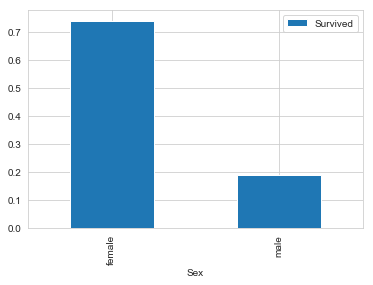

In [40]:
# 由于Survived的值是0/1，因此可以通过求取平均值，来得到 男活/男总数 女活/女总数 的存活率
train[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

#### 1.2.2船舱等级与存活之间的关系

可以发现船舱等级越高，存活率越高
从图和表中可以看出，总体上泰坦尼克号逃生是妇女优先，但是对于不同等级的船舱还是有一定的区别。

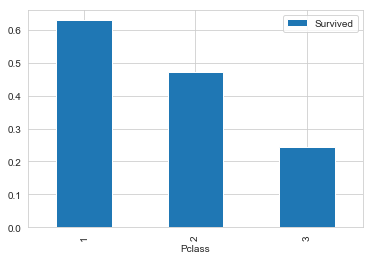

In [41]:
train[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()

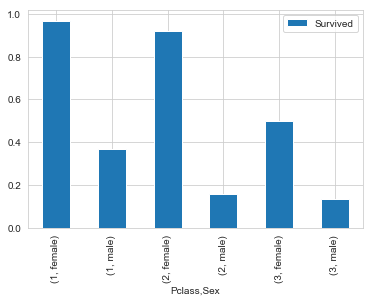

In [45]:
train[['Sex', 'Pclass','Survived']].groupby(['Pclass', 'Sex']).mean().plot.bar()

## 泰坦尼克

In [ ]:
def read_dataset(fn):
    data = pd.read_csv(fn, index_col=0)
    data.drop(['Name', 'Ticket', 'Cabin'],axis=1, inplace=True)
    data['Sex'] = (data['Sex'] == 'male').astype("int")
    labels = data['Embarked'].unique().tolist()
    data['Embarked'] = data['Embarked'].apply(lambda n: labels.index(n))
    data = data.fillna(0)
    return data
train = read_dataset("../data/7_titanic/train.csv")
train.head()

In [ ]:
from sklearn.model_selection import train_test_split
y = train['Survived'].values
X = train.drop(['Survived'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("train:{0}, test:{1}".format(X_train.shape, X_test.shape))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(train_score, test_score)

In [ ]:
# 搜索出最优参数
def cv_score(d):
    clf = DecisionTreeClassifier(criterion='gini',max_depth=d)
    clf.fit(X_train, y_train)
    tr_core = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    return (tr_core, test_score)
depths = range(2, 15)
scores = [cv_score(d) for d in depths]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

best_score_index = np.argmax(cv_scores)
best_score = cv_scores[best_score_index]
best_param = depths[best_score_index]
print(best_score, best_param)


In [ ]:
#画出参数形状
plt.figure(figsize=(6, 4), dpi=144)
plt.grid()
plt.xlabel('max depth of decision tree')
plt.ylabel('score')
plt.plot(depths, cv_scores, '.g-', label='cv_score')
plt.plot(depths, tr_scores, '.r--', label='train_score')
plt.legend()

In [ ]:
def cv_score(val):
    clf = DecisionTreeClassifier(criterion='gini', min_impurity_split=val)
    clf.fit(X_train, y_train)
    tr_score = clf.score(X_train, y_train)
    cv_score = clf.score(X_test, y_test)
    return (tr_score, cv_score)

min_impurity_split_values = np.linspace(0, 0.5,50)
scores = [cv_score(v) for v in min_impurity_split_values]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]
print("best param:{0}, best score:{1}".format(min_impurity_split_values[np.argmax(cv_scores)], cv_scores[np.argmax(cv_scores)]))

In [ ]:
#画出参数形状   
plt.figure(figsize=(6, 4), dpi=144)
plt.grid()
plt.xlabel('threshold of entropy')
plt.ylabel('score')
plt.plot(min_impurity_split_values, cv_scores, '.g-', label='cv_score')
plt.plot(min_impurity_split_values, tr_scores, '.r--', label='train_score')
plt.legend()

In [ ]:
# 使用网格搜索GridSearchCV
# 单组参数进行搜索
from sklearn.model_selection import GridSearchCV
thresholds = np.linspace(0, 0.5, 50)
param_grid = {'min_impurity_split':thresholds}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf.fit(X, y)
print(clf.best_params_, clf.best_score_)
# plot_curve()


In [ ]:
# 多组参数进行搜索
from sklearn.model_selection import GridSearchCV
entropy_thresholds = np.linspace(0, 1, 50)
gini_thresholds = np.linspace(0, 0.5, 50)

# 矩阵
params_grid = [{
                   'criterion':['entropy'],
                   'min_impurity_split':entropy_thresholds
               },
               {
                   'criterion':['gini'],
                   'min_impurity_split':gini_thresholds
               },
               {
                   'max_depth':range(2, 10)
               },
               {
                   'min_samples_split':range(2, 30, 2)
               }]

clf = GridSearchCV(DecisionTreeClassifier(), params_grid, cv=3)
clf.fit(X,y)
print('best params:{0}, best score:{1}'.format(clf.best_params_, clf.best_score_))